# Analiza porównawcza manuskryptu Wojnicza i tekstów katalońskich
## Autorzy: Konrad Reczko, Joanna Wójcicka

# Import bibliotek

In [164]:
import re
from matplotlib import pyplot as plt
import numpy as np
import scipy
import requests

# Wczytanie danych oraz przygotowanie ich do analizy

In [165]:
class DataGetterManuscript:
    def __init__(self, path):
        self.data = None
        self.paragraphs = []
        self.words = []

        with open(path, 'r', encoding='utf-8') as file:
            self.data = file.read()
        self.data = self.data.split('\n')
        pass
    def get_paragraphs_from_voynich(self):
        """
        Removes comments from data and splits it into the paragraphs
        """
        processed_data = []
        for x in self.data:
            if x.strip().startswith("#") or len(x) < 2:
                continue
            processed_data.append(x)
        curr_paragraph = []
        for x in processed_data:
            if x[-1] == '-':
                curr_paragraph.append(x[:-1])
            elif x[-1] == '=':
                curr_paragraph.append(x[:-1])
                self.paragraphs.append(curr_paragraph)
                curr_paragraph = []

    def get_paragraphs(self):
        """
        Removes comments from data and splits it into the paragraphs
        """
        curr_paragraph = []
        for x in self.data:
            # Skip empty lines or comments
            if not x.strip():
                continue
            line = x.rstrip('\n')
            if '\n' in x:
                curr_paragraph.append(line)
                self.paragraphs.append(curr_paragraph)
                curr_paragraph = []
            else:
                curr_paragraph.append(line)

        if curr_paragraph:
            self.paragraphs.append(curr_paragraph)

    def remove_ambiguous(self):
        """
        The voynich manuscript contains some ambiguous characters. They are being marked as [A|B|C] and so on. This function removes them by choosing only the first option in our example case it would be A
        """
        for paragraph in self.paragraphs:
            for i in range(len(paragraph)):
                if paragraph[i] == '[':
                    paragraph[i] = paragraph[i+1]
                    while paragraph[i] != ']':
                        paragraph.pop(i+1)
                    paragraph.pop(i+1)

    def get_words(self):
        for paragraph in self.paragraphs:
            for line in paragraph:
                words_in_line = [word for word in re.split(r'\W+', line) if word]
                self.words.extend(words_in_line)

        return self.words

    def process_formatted_data(self) -> list[list[str]]:
        """
        It takes voynich manuscript data and removes all unnecessary lines and characters. It returns list of paragraphs with words
        """
        self.get_paragraphs_from_voynich()
        self.remove_ambiguous()
        self.get_words()
        return self.words

    def process_unformatted_data(self) -> list[list[str]]:
        """
        It takes voynich manuscript data and removes all unnecessary lines and characters. It returns list of paragraphs with words
        """
        self.get_paragraphs()
        self.get_words()
        return self.words

# Wczytanie danych
Badać będziemy dwa zbiory danych:
- manuskrypt Wojnicza
- teksty katalońskie (będą one połączeniem różnych tekstów, aby zachować podobną liczbę słów) - będzie to Powszechna deklaracja praw człowieka, konstytucja hiszpańska oraz fragmenty tekstów z Wikipedii (o Ziemi oraz Hiszpanii).

Ważnym jest, aby w obu przypadkach zachować podobną liczbę słów, aby móc miarodajnie porównać wyniki.

In [166]:
voynich =  DataGetterManuscript("text_samples/voynich.txt")
voynich.process_formatted_data()

catalan = DataGetterManuscript("text_samples/catalan.txt")
catalan.process_unformatted_data()

print("Voynich manuscript words: ", len(voynich.words))
print("Catalan words: ", len(catalan.words))

Voynich manuscript words:  35655
Catalan words:  35342


# Prawo Zipfa
Prawo Zipfa jest jednym z empirycznych praw, które opisuje zjawisko występujące w różnych zbiorach danych, zwłaszcza w językoznawstwie. Stwierdza ono, że w każdym naturalnym języku najczęściej używane słowo pojawia się dwa razy częściej niż drugie najczęściej używane słowo, trzy razy częściej niż trzecie najczęściej używane słowo, i tak dalej. Innymi słowy, częstotliwość występowania każdego słowa jest odwrotnie proporcjonalna do jego rangi w rankingu częstotliwości

In [167]:
def NGramsCount(words: list[str], n: int) -> dict[str, int]:
    """
    Returns dictionary of n-grams and their counts
    words - list of words
    c - n-gram count
    """
    ngrams = {}
    for i in range(len(words) - n + 1):
        ngram = ' '.join(words[i:i+n])
        if ngram in ngrams:
            ngrams[ngram] += 1
        else:
            ngrams[ngram] = 1

    return ngrams
def getNGramFrequencySorted(ngrams: dict[str, int, int]) -> list[tuple[str, int]]:
    """
    Returns list of tuples (ngram, frequency) sorted by frequency
    """
    ngram_freq = {}
    for ngram in ngrams.keys():
        ngram_freq[ngram] = ngrams[ngram] / len(ngrams)

    sorted_freq = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)

    return sorted_freq

def getNGramScores(ngrams: dict[str, int, int]) -> list[tuple[str, int]]:
    """
    Returns list of tuples (ngram, score) sorted by score (score = rank * frequency)
    """
    sorted_freq = getNGramFrequencySorted(ngrams)

    scores = []
    for i in range(len(sorted_freq)):
        scores.append((i + 1 * sorted_freq[i][1], sorted_freq[i][0]))
    return scores

Aby sprawdzić zachowanie prawa Zipfa dla obu zbiorów danych, wyodrębniliśmy 1-gramy i posortowaliśmy je według częstości występowania.

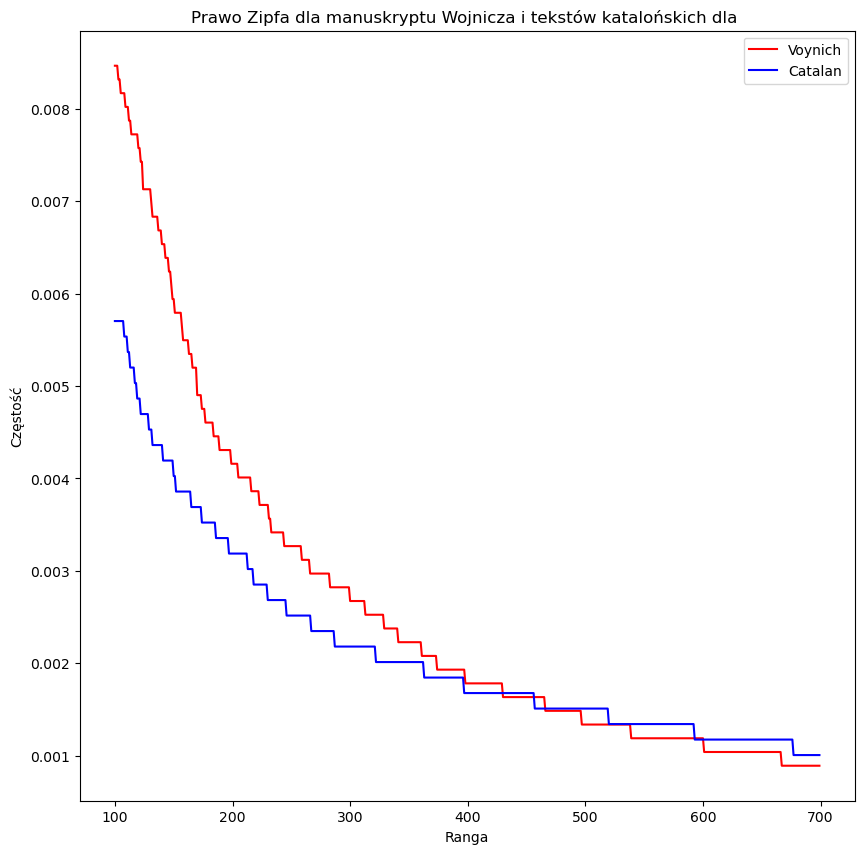

In [168]:
plt.figure(figsize=(10, 10))
plt.title("Prawo Zipfa dla manuskryptu Wojnicza i tekstów katalońskich dla ")
plt.xlabel("Ranga")
plt.ylabel("Częstość")
plt.plot([x for x in range(100, 700)], [x[1] for x in getNGramFrequencySorted(NGramsCount(voynich.words, 1))][100:700], 'r')
plt.plot([x for x in range(100, 700)], [x[1] for x in getNGramFrequencySorted(NGramsCount(catalan.words, 1))][100:700], 'b')
plt.legend(["Voynich", "Catalan"])
plt.show()

Następnie wyliczony został score w kontekście prawa Zipfa. Score jest to iloczyn rangi oraz częstości występowania danego słowa. W idealnym przypadku zgodnym z prawem Zipfa, wartość tego iloczynu powinna być mniej więcej stała dla wszystkich słów, ponieważ częstość słowa jest odwrotnie proporcjonalna do jego rangi.
Na tym wykresie widzimy, że dla tekstów katalońskich linia jest płaska, co oznacza, że iloczyn rangi i częstości jest stosunkowo stały, a zatem teksty te dobrze zgadzają się z prawem Zipfa. Dla manuskryptu Wojnicza wartości "score" pokrywają się z wartościami dla tekstów katalońskich.

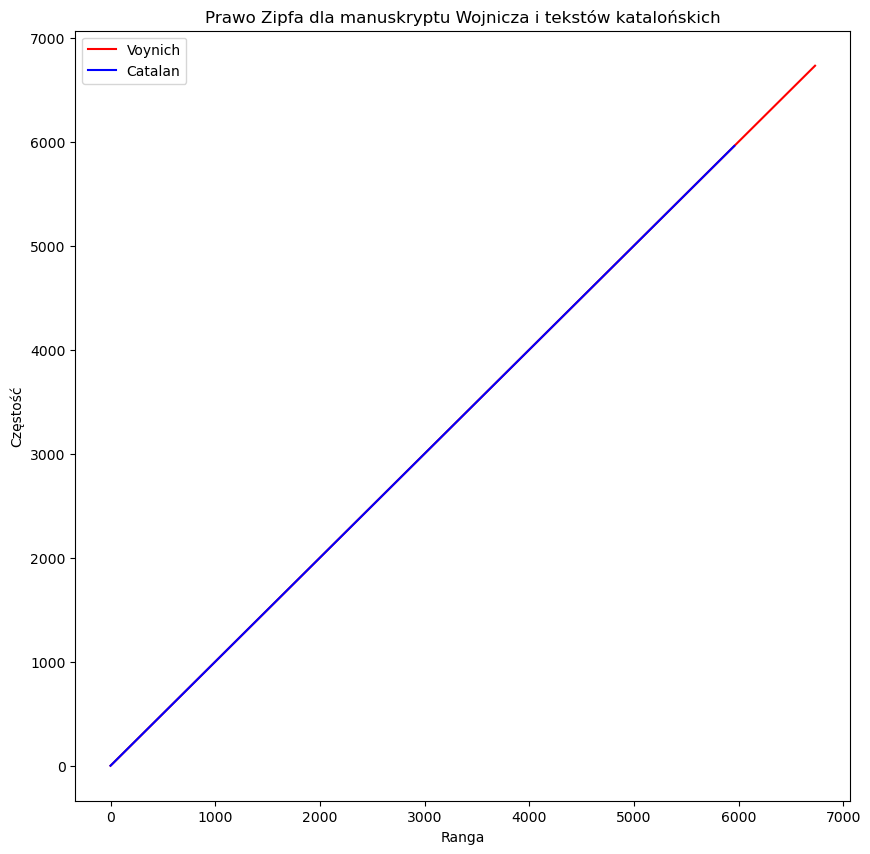

In [169]:
plt.figure(figsize=(10, 10))
plt.title("Prawo Zipfa dla manuskryptu Wojnicza i tekstów katalońskich")
plt.xlabel("Ranga")
plt.ylabel("Częstość")
plt.plot([x for x in range(0, len(getNGramScores(NGramsCount(voynich.words, 1))))], [x[0] for x in getNGramScores(NGramsCount(voynich.words, 1))], 'r')
plt.plot([x for x in range(0, len(getNGramScores(NGramsCount(catalan.words, 1))))], [x[0] for x in getNGramScores(NGramsCount(catalan.words, 1))], 'b')
plt.legend(["Voynich", "Catalan"])
plt.show()

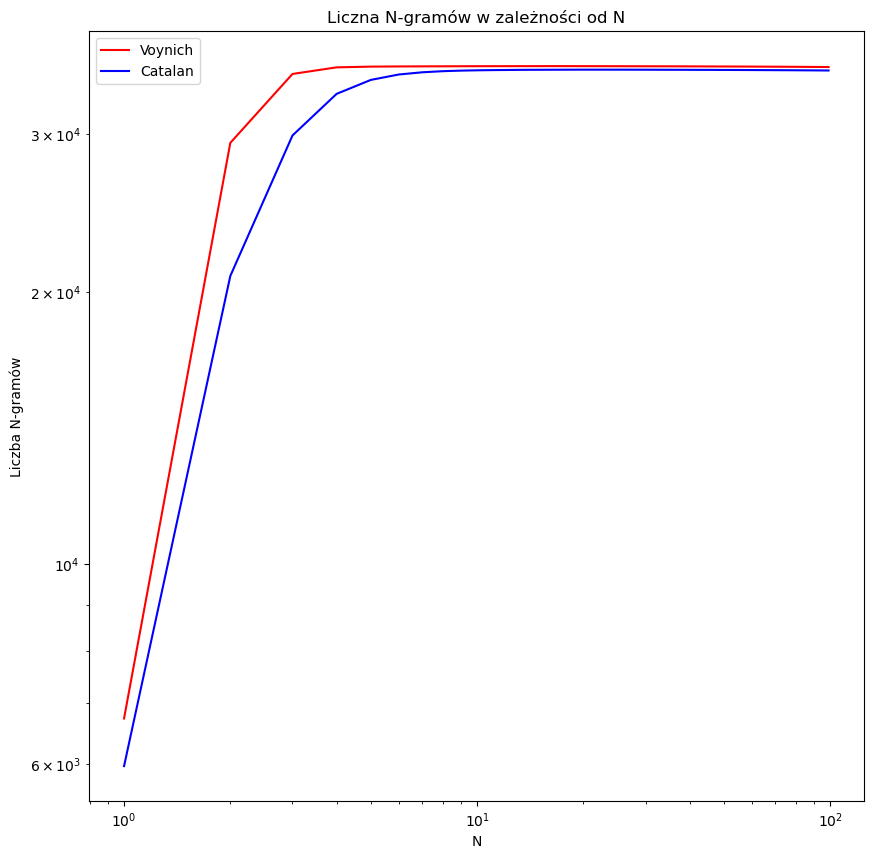

In [170]:
Nmax = 100
plt.figure(figsize=(10, 10))
plt.title("Liczna N-gramów w zależności od N")
plt.xlabel("N")
plt.ylabel("Liczba N-gramów")
plt.yscale("log")
plt.xscale("log")
plt.plot([x for x in range(1, Nmax)], [len(NGramsCount(voynich.words, x)) for x in range(1, Nmax)], 'r')
plt.plot([x for x in range(1, Nmax)], [len(NGramsCount(catalan.words, x)) for x in range(1, Nmax)], 'b')
plt.legend(["Voynich", "Catalan"])
plt.show()

## Wnioski
Wyniki analizy prawa Zipfa pokazują, że manuskrypt Wojnicza jest bardzo zbliżony do tekstów w języku katalońskim. W obu przypadkach nie można określić, że prawo to nie jest spełnione w znaczącym stopniu. Można zauważyć, że tekst Wojnicza przyjmuje pewne charakterystyki języka naturalnego, co może sugerować, że jest to język naturalny, a nie sztuczny. Jednakże spełnienie prawa Zipfa nie jest wystarczające, aby móc stwierdzić, że dany tekst jest rzeczywiście językiem naturalnym.

# N-gramy i ich interpretacja
N-gram to termin używany w językoznawstwie i przetwarzaniu języka naturalnego (NLP), który odnosi się do ciągu "n" kolejnych elementów z danego tekstu lub mowy. Elementy te mogą być fonemami, sylabami, literami, słowami lub bazowymi parami zależnie od zastosowania. N-gramy są używane do modelowania języka naturalnego w sposób, który pozwala na przewidywanie kolejności pojawiania się elementów.

In [171]:
def getNGramsOccuringMoreThanOnce(words: list[str], n: int) -> dict[str, int]:
    """
    Returns dictionary of n-grams and their counts
    words - list of words
    c - n-gram count
    """
    ngrams = {}
    for i in range(len(words) - n + 1):
        ngram = ' '.join(words[i:i+n])
        if ngram in ngrams:
            ngrams[ngram] += 1
        else:
            ngrams[ngram] = 1

    return {k: v for k, v in ngrams.items() if v > 1}

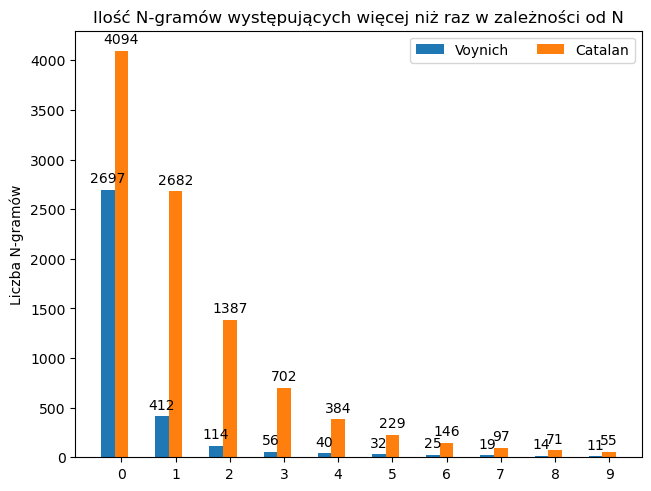

In [172]:
Nmax = 10
a = [len(getNGramsOccuringMoreThanOnce(voynich.words, x)) for x in range(2, Nmax + 2)]
b = [len(getNGramsOccuringMoreThanOnce(catalan.words, x)) for x in range(2, Nmax + 2)]
x = np.arange(Nmax)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in [('Voynich', a), ('Catalan', b)]:
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Liczba N-gramów')
ax.set_title('Ilość N-gramów występujących więcej niż raz w zależności od N')
ax.set_xticks(x + width, x)
ax.legend(loc='upper right', ncols=3)

plt.show()

## Wnioski
Na podstawie przedstawionego wykresu, który pokazuje liczbę N-gramów występujących więcej niż raz w zależności od N dla manuskryptu Wojnicza i tekstów w języku katalońskim, można wysnuć kilka wniosków:
- Spadek liczby N-gramów z wzrostem N: Dla obu zestawów danych widać wyraźny spadek liczby N-gramów w miarę wzrostu N. Jest to typowy wzorzec, ponieważ większe N-gramy są mniej powszechne – im więcej elementów w sekwencji, tym mniejsza szansa, że sekwencja ta pojawi się więcej niż raz.
- Porównanie zbiorów danych: Manuskrypt Wojnicza ma mniej N-gramów dla każdego N w porównaniu z tekstami katalońskimi. Może to być wynikiem wąskiej tematyki manuskryptu Wojnicza lub specyficznej natury jego języka, która może być mniej zróżnicowana niż pełnoprawny język naturalny.

In [173]:
# Nmax = 10
# a = list(getNGramsOccuringMoreThanOnce(voynich.words, 2))[:Nmax]
# b = list(getNGramsOccuringMoreThanOnce(catalan.words, 2))[:Nmax]
# x = [x + y for x, y in (a[1], b[1])]  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0
#
# fig, ax = plt.subplots(layout='constrained')
#
# for attribute, measurement in [('Voynich', a), ('Catalan', b)]:
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1
#
# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Liczba N-gramów')
# ax.set_title('Najczęstsze N-gramy')
# ax.set_xticks(x + width, x)
# ax.legend(loc='upper right', ncols=3)
#
# plt.show()


# ????????????????????????????

# Graf połączeń słów


In [211]:
def getWordGraph(words: list[str], min_count: int) -> (dict[str, dict[str, int]], dict[str, dict[str, int]]):
    """
    Returns forward and backward graph of words with word counts
    forward_graph - dictionary of words and their following words
    backward_graph - dictionary of words and their preceding words
    """
    forward_graph = {}
    backward_graph = {}
    for i in range(len(words) - 1):
        word = words[i]
        next_word = words[i + 1]
        if word not in forward_graph:
            forward_graph[word] = {next_word: 1}
        else:
            next_words = forward_graph[word]
            if next_word not in next_words:
                next_words[next_word] = 1
            else:
                next_words[next_word] += 1

            if next_word not in backward_graph:
                backward_graph[next_word] = {word: 1}
            else:
                previous_words = backward_graph[next_word]
                if word not in previous_words:
                    previous_words[word] = 1
                else:
                    previous_words[word] += 1

    forward_graph = {k: v for k, v in forward_graph.items() if sum(v.values()) > min_count}
    backward_graph = {k: v for k, v in backward_graph.items() if sum(v.values()) > min_count}

    return forward_graph, backward_graph

def filteredWordGraph(words: list[str], min_count: int) -> (dict[str, dict[str, int]], dict[str, dict[str, int]]):
    """
    Returns filtered graph with words that occur more than min_count times
    """
    forward_graph, backward_graph = getWordGraph(words, min_count)

    forward_all_words = set(forward_graph.keys())
    backward_all_words = set(backward_graph.keys())

    filtered_forward = {k: {word: count for word, count in v.items() if word in forward_all_words}
            for k, v in forward_graph.items() }
    filtered_backward = {k: {word: count for word, count in v.items() if word in backward_all_words}
            for k, v in backward_graph.items() }

    return filtered_forward, filtered_backward

In [208]:
def visualizeBipartiteGraph(graph_data: tuple[dict, dict], graph_title: str):
    """
    Visualizes a bipartite graph from two dictionaries representing forward and backward connections.
    """
    plt.figure(figsize=(30, 30))
    plt.title(graph_title)
    plt.axis("off")

    forward_links, backward_links = graph_data

    # Find the maximum link count for scaling
    max_link_count = max(max(count.values()) for count in forward_links.values())

    # Extract and sort all unique words
    unique_words = set(forward_links).union(*forward_links.values())
    sorted_words = sorted(unique_words)
    word_positions = {word: pos for pos, word in enumerate(sorted_words)}

    # Plot the edges
    for source_word, targets in forward_links.items():
        for target_word, weight in targets.items():
            weight_normalized = weight / max_link_count

            source_pos = word_positions[source_word]
            target_pos = word_positions[target_word]

            plt.plot([0, 1], [source_pos, target_pos], color=(0, 0, 1, weight_normalized), lw=2)
            plt.text(-0.1, source_pos, source_word, ha='right', va='center')
            plt.text(1.1, target_pos, target_word, ha='left', va='center')


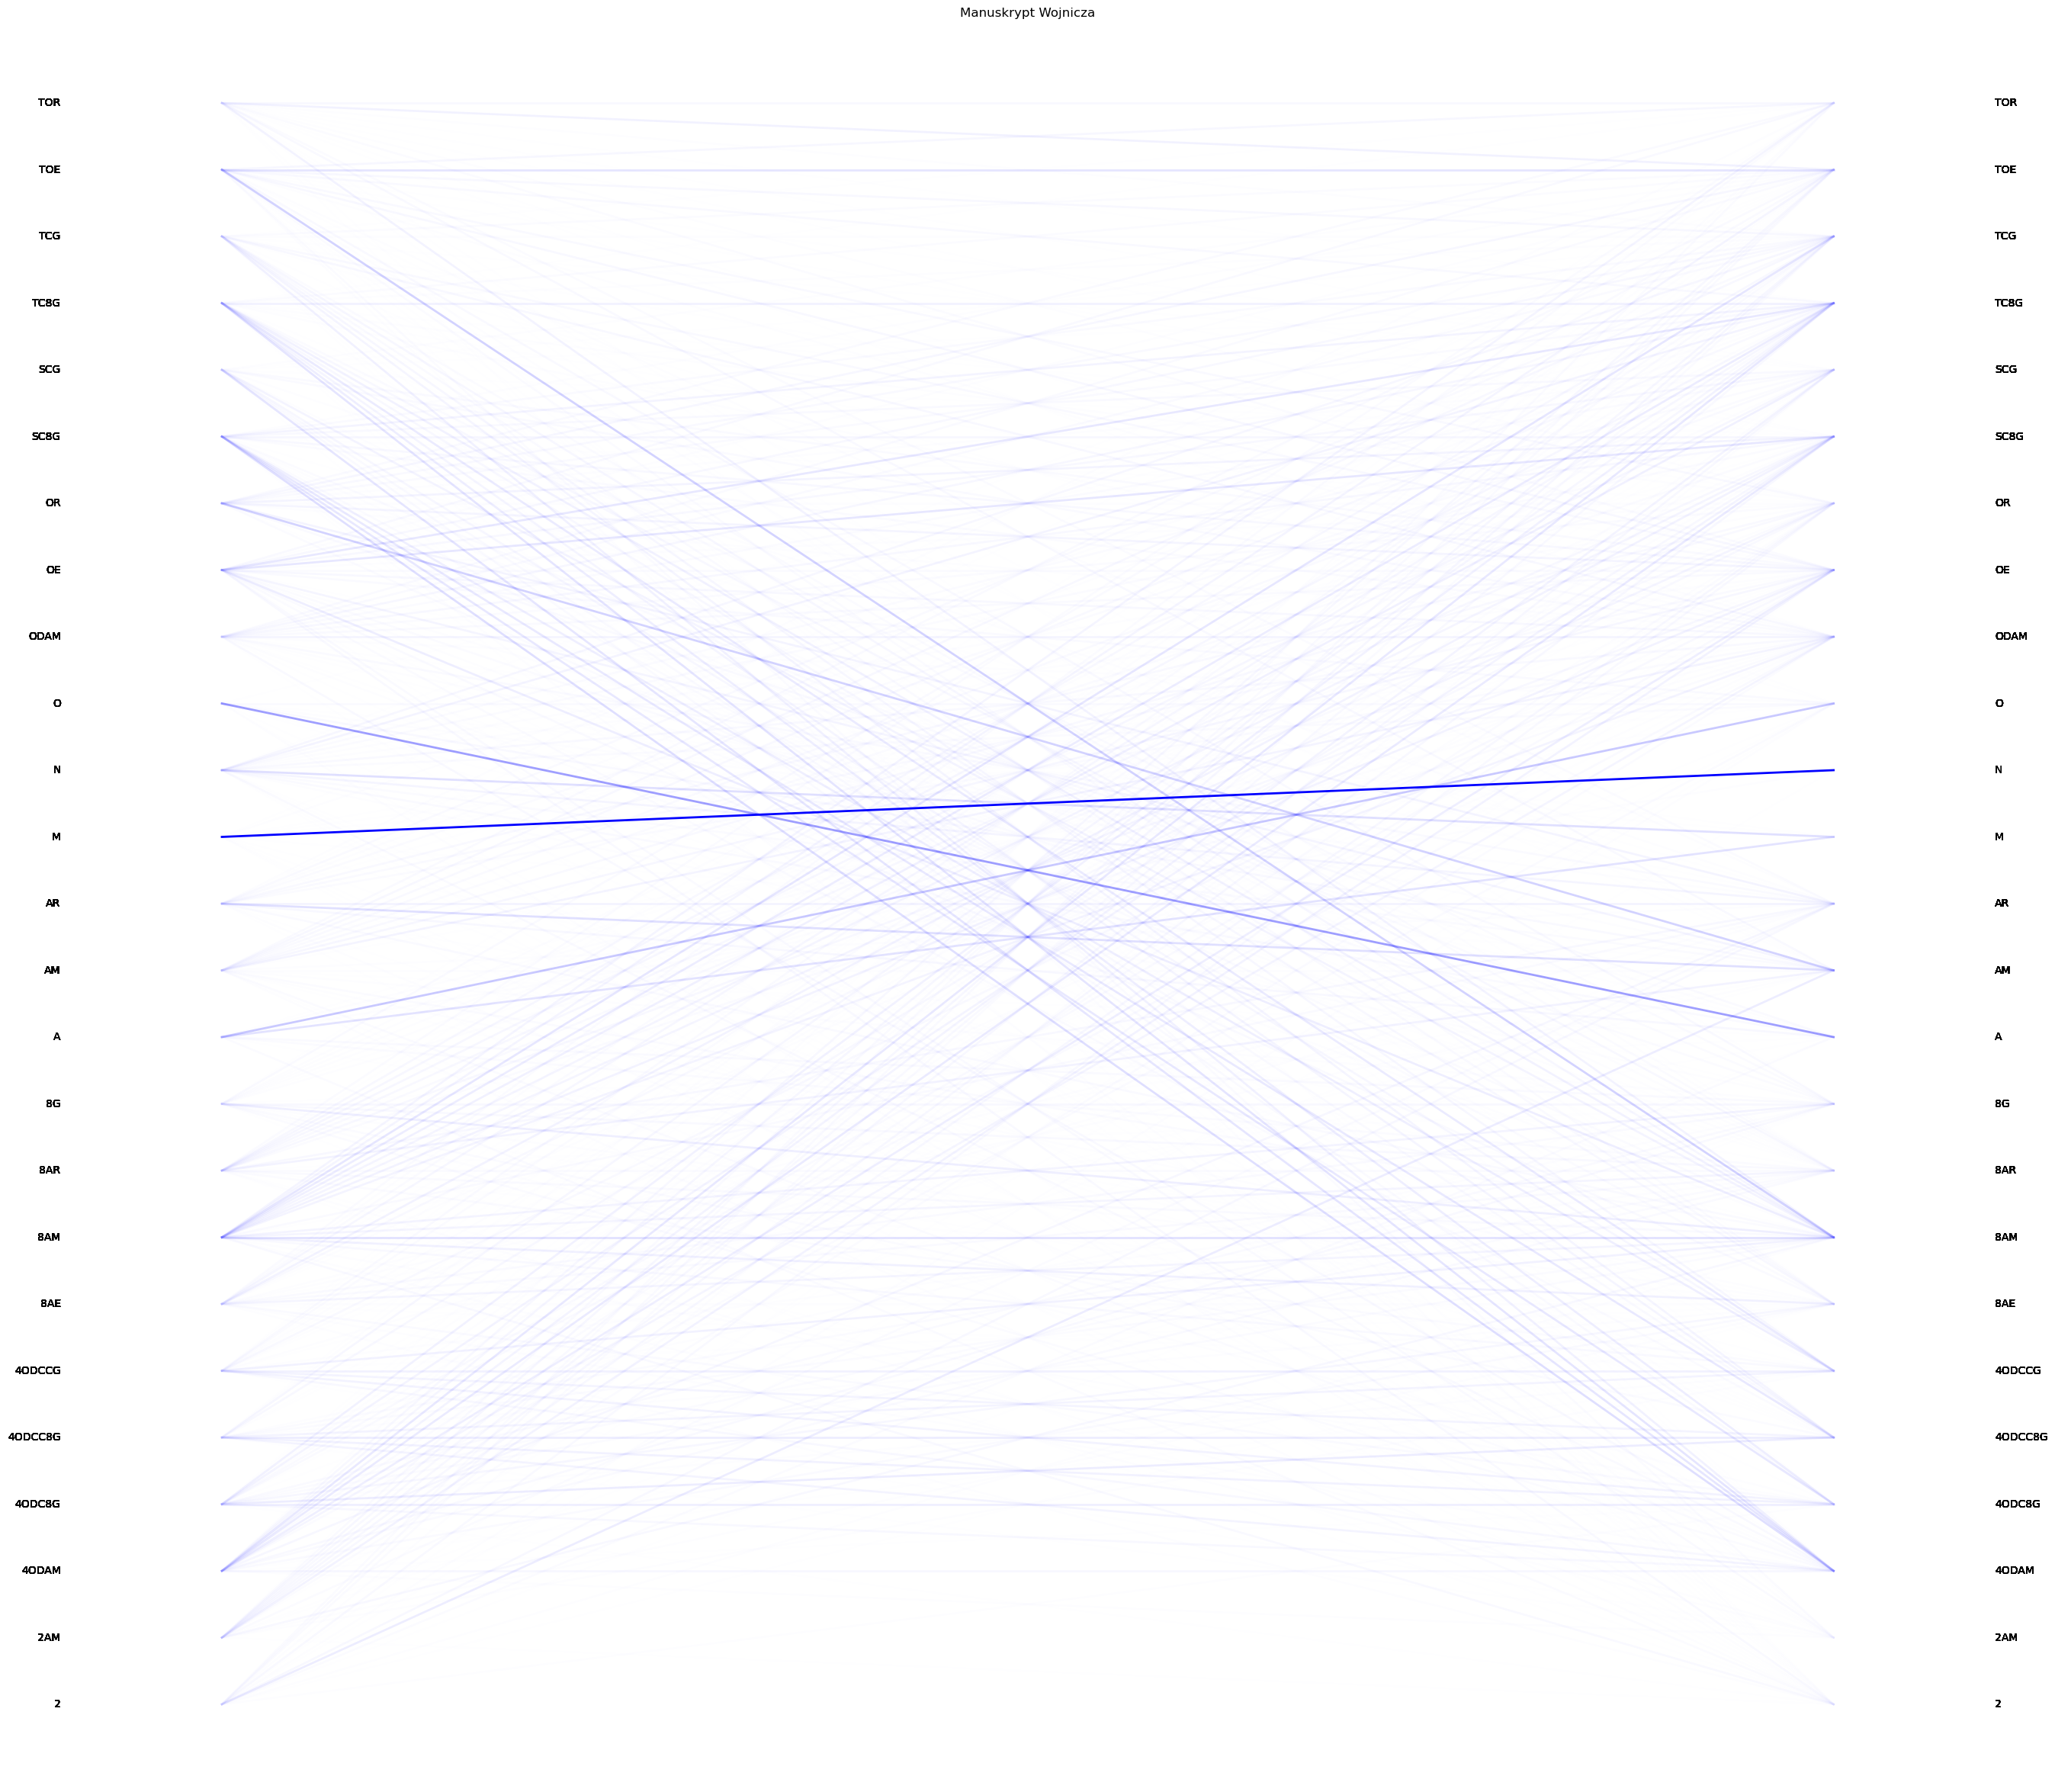

In [209]:
visualizeBipartiteGraph(filteredWordGraph(voynich.words, 200), "Manuskrypt Wojnicza")

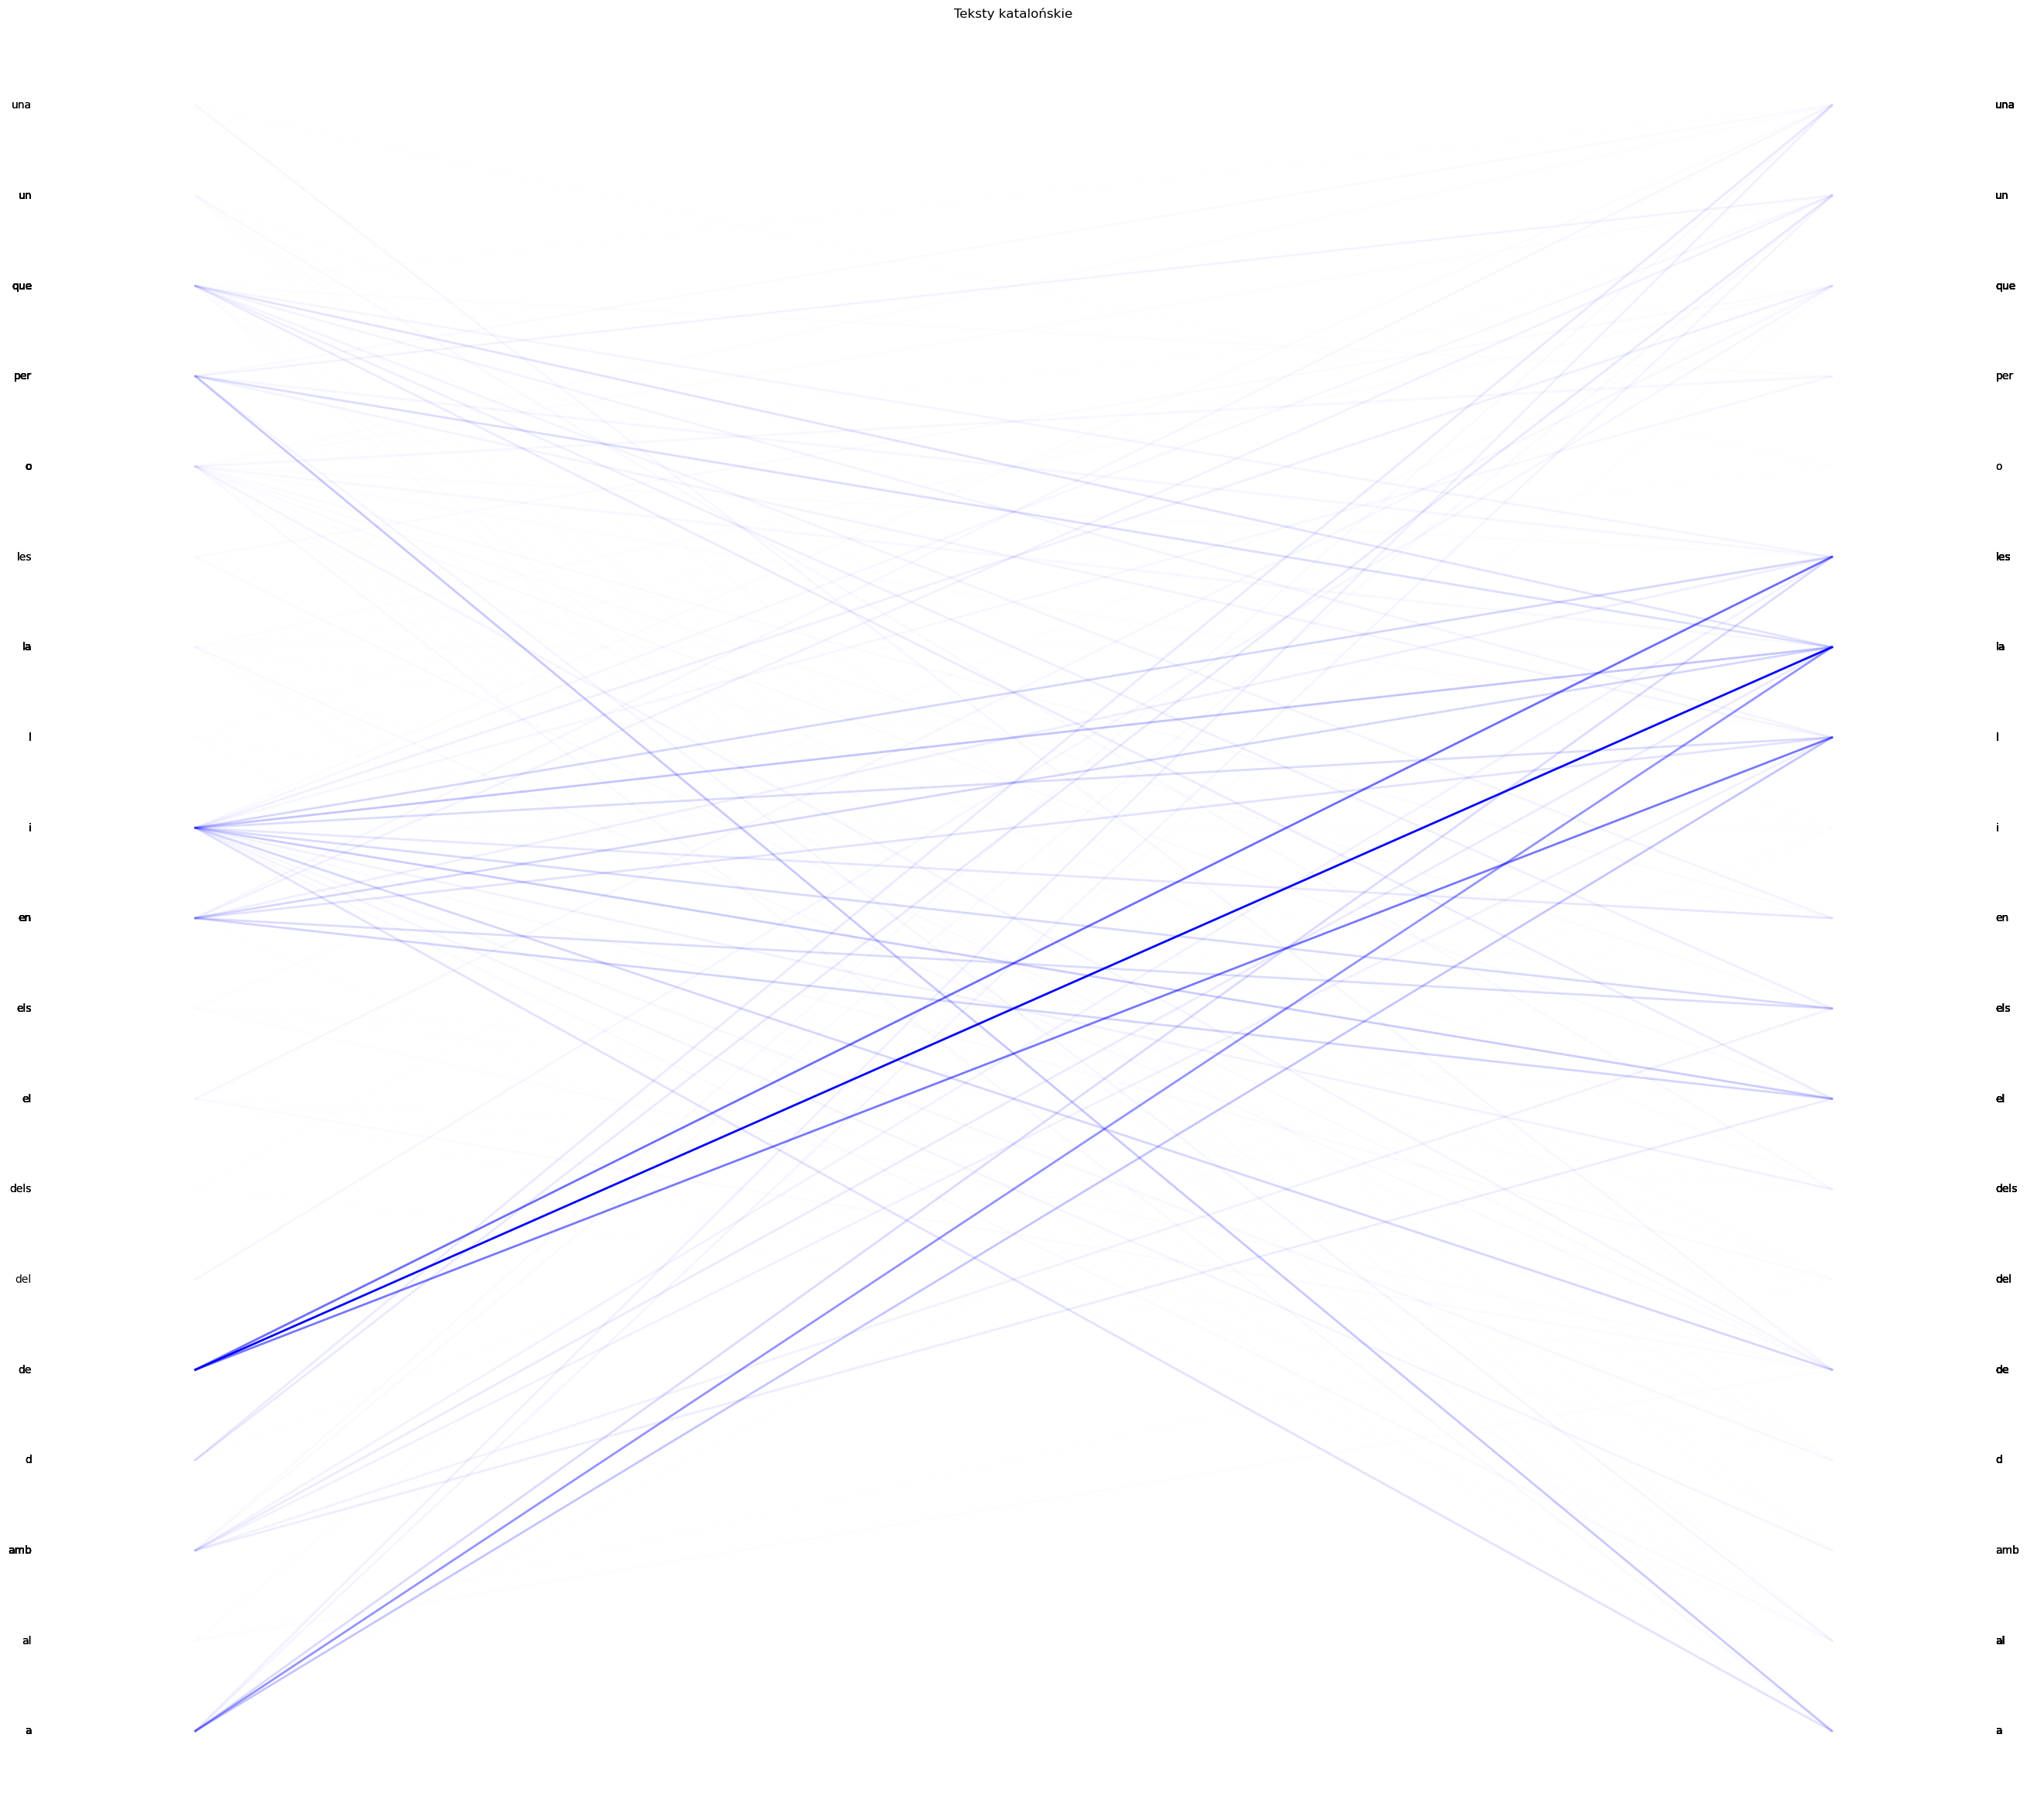

In [210]:
visualizeBipartiteGraph(filteredWordGraph(catalan.words, 200), "Teksty katalońskie")

## Wnioski
Patrząc na oba grafy można zauważyć, iż graf dla manuskryptu Wojnicza jest gęstszy, niż dla tekstów w języku katalońskim. Może to wynikać z paru powodów:
- Rozmiar słownictwa i powtarzalność: Manuskrypt Wojnicza może charakteryzować się mniejszym i bardziej powtarzalnym słownictwem w porównaniu z tekstami katalońskimi. Jeśli te same słowa są używane częściej obok siebie w manuskrypcie Wojnicza, prowadzi to do większej gęstości grafu, ponieważ te same połączenia (krawędzie) między słowami (węzłami) występują częściej.
- Struktura tekstów: Manuskrypt Wojnicza może posiadać strukturę, która z natury prowadzi do częstszego parowania tych samych słów. Może to być wynikiem formułek, powtarzalnych fraz lub ograniczonego zestawu opisywanych koncepcji.
Podsumowując, manuskrypt Wojnicza wykazuje większą gęstość grafu, co może wskazywać na jego specyficzne cechy językowe i strukturalne, różniące się od tekstów katalońskich.

# Podsumowanie i wnioski
Analiza manuskryptu Wojnicza i porównanie go z tekstami w języku katalońskim ujawniają, że manuskrypt zawiera elementy charakterystyczne dla języków naturalnych. Niemniej jednak, nie ma wystarczających dowodów, by z całą pewnością określić manuskrypt jako zapis w języku naturalnym. Struktury językowe znalezione w manuskrypcie mogą być także właściwe dla języków sztucznych, które naśladują naturalne modele lingwistyczne. Jeśli zatem przyjąć, że manuskrypt Wojnicza reprezentuje język skonstruowany, to musiałby być on wyjątkowo zaawansowany i wyrafinowany, naśladując złożoność prawdziwych języków ludzkich w stopniu dotąd niespotykanym w innych językach sztucznych.